In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

import numpy as np
from mpl_toolkits import mplot3d
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as optimize

from LimitedCommitmentModel import LimitedCommitmentModelClass

# plot style
linestyles = ['-','--','-.',':',':']
markers = ['o','s','D','*','P']
linewidth = 2
font_size = 17
font = {'size':font_size}
matplotlib.rc('font', **font)

plt.rcParams.update({'figure.max_open_warning': 0,'text.usetex': False})
path = 'output/'

SAVE = False

# c++ settings
do_compile = True
threads = 16

In [2]:
# compile c++ files
# model = LimitedCommitmentModelClass(par={'threads':threads })
# model.link_to_cpp(force_compile=do_compile)

# Solve and simulate from alternative models

In [3]:
# settings for models to solve
T = 2
specs = {
    # 'model 1':{'latexname':'$\sigma_{\psi}=0$', 'par':{'sigma_love':0.0,'T':T,'threads':threads}},
    # 'model 2':{'latexname':'$\sigma_{\psi}=0.04$', 'par':{'sigma_love':0.04,'T':T,'threads':threads}},
    'model 3':{'latexname':'$\sigma_{\psi}=0.1$', 'par':{'sigma_love':0.1,'T':T,'threads':threads}},
    # 'model 4':{'latexname':'$\kappa_w=0.3$', 'par':{'div_A_share':0.3,'sigma_love':0.0,'T':T,'threads':threads}},
}


In [4]:
# solve different models
models = {}
for m,(name,spec) in enumerate(specs.items()):
    print(f'{name} loading...',end='')
    
    # setup model
    models[name] = LimitedCommitmentModelClass(name=name,par=spec['par'])
    if do_compile & (m==0):
        compile_now = True
    else:
        compile_now = False
    models[name].link_to_cpp(force_compile=compile_now)
    models[name].spec = spec
    
    print(' solving...')
    %time models[name].solve() #Wall time: 15min 44s

model 3 loading... solving...
Wall time: 7min 13s


# Policy functions

## Singles

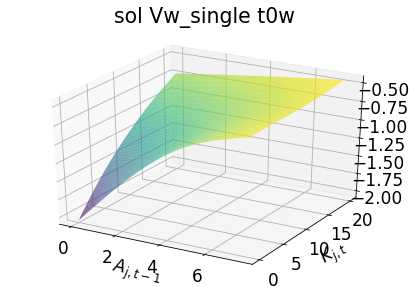

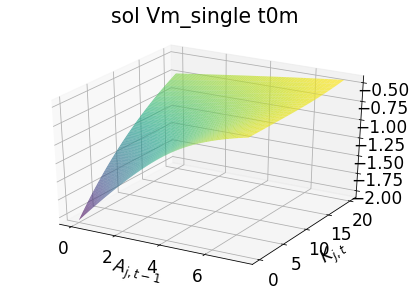

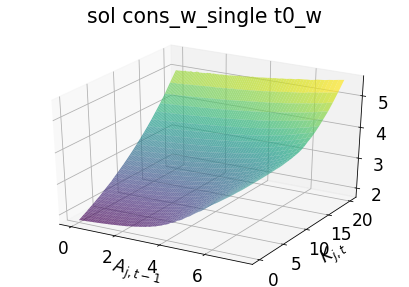

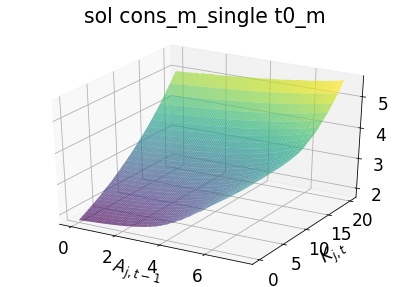

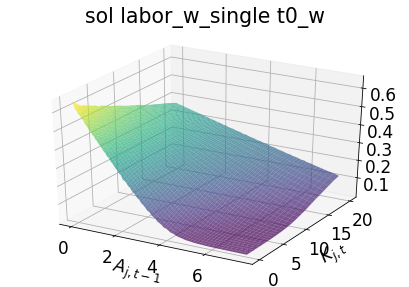

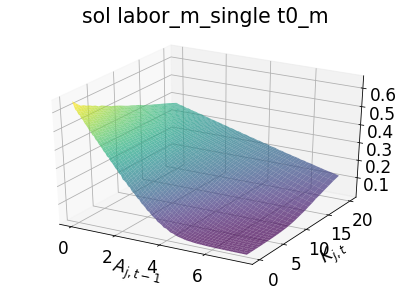

In [5]:
model_list = ('model 3',)
sol_type ='single'
par = models[model_list[0]].par

cmaps = ('viridis','gray')
for t in (0,):
    for var in ('V','cons','labor'):
        for sex in (1,2):
            sex_str = 'w' if sex==1 else 'm'
            if var not in ('V',):
                sex_str = f'_{sex_str}'
            var_now = var
            var_now += f'{sex_str}_{sol_type}'
            
            fig = plt.figure()
            ax = plt.axes(projection='3d')

            grid_A = par.grid_Aw if sex==1 else par.grid_Am
            X, Y = np.meshgrid(grid_A, par.grid_K,indexing='ij')
            
            for i,name in enumerate(model_list):
                model = models[name]
                
                Z = getattr(model.sol,var_now)[t]
                
                alpha = 0.5 if name=='model 1' else 0.7
                ax.plot_surface(X, Y, Z,rstride=1,cstride=1,cmap=cmaps[i], edgecolor='none',alpha=alpha);
                
                ax.set(xlabel='$A_{j,t-1}$',ylabel='$K_{j,t}$');
                
            fig_name = f'sol {var_now} t{t}{sex_str}'
            plt.tight_layout()
            if SAVE: 
                plt.savefig(path+fig_name+'.pdf')
            else:
                ax.set(title=fig_name)

## Couples
Plot policy functions as a function of woman's power and household wealth

9.90750257112823


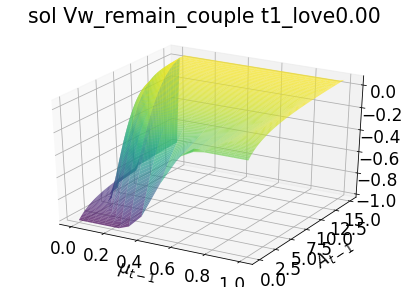

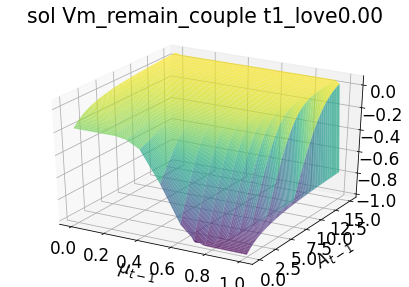

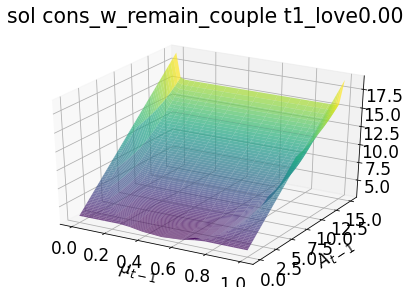

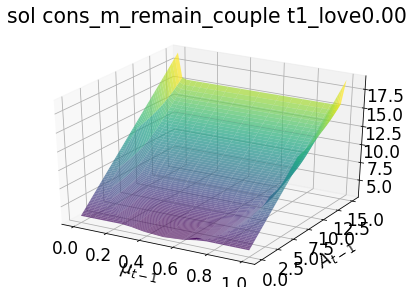

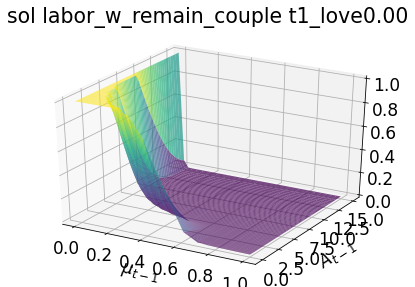

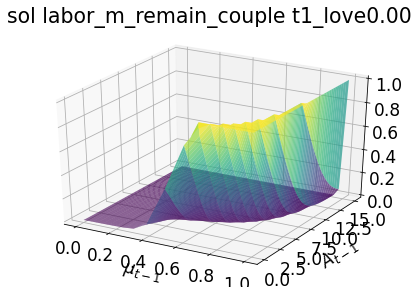

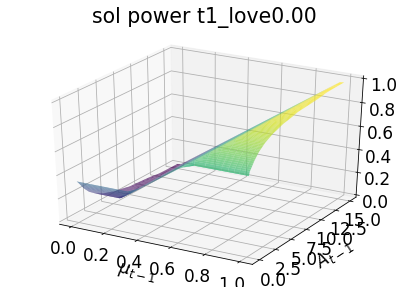

In [6]:

model_list = ('model 3',)
sol_type ='remain_couple'
par = models[model_list[0]].par



t = par.T-1
iK = 5
iKw = iK
iKm = iK

print(np.mean(model.sol.cons_w_remain_couple[t].ravel())) # 9.90750257112823 t=T-1

X, Y = np.meshgrid(par.grid_power, par.grid_A,indexing='ij')

cmaps = ('viridis','gray')
for iL in (par.num_love//2,): 
    for var in ('Vw','Vm','cons_w','cons_m','labor_w','labor_m','power'):
        if var != 'power': 
            var += f'_{sol_type}'
        
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        
        for i,name in enumerate(model_list):
            model = models[name]
            
            Z = getattr(model.sol,var)[t,:,iL,:,iKw,iKm]
            
            
            alpha = 0.5 if name=='model 1' else 0.7
            ax.plot_surface(X, Y, Z,rstride=1,cstride=1,cmap=cmaps[i], edgecolor='none',alpha=alpha);
            
            if var == 'power': 
                ax.set(zlim=[0.0,1.0])
            ax.set(xlabel='$\mu_{t-1}$',ylabel='$A_{t-1}$');
            
        fig_name = f'sol {var} t{t}_love{np.round(par.grid_love[iL]):1.2f}'
        plt.tight_layout()
        if SAVE: 
            plt.savefig(path+fig_name+'.pdf')
        else:
            ax.set(title=fig_name)

In [7]:
print(np.mean(model.sol.EVw_pd.ravel())) # -0.3062966091195685 t=T-1

-0.3062966091195685


In [8]:
stop

NameError: name 'stop' is not defined

# Simulated paths

In [ ]:
SAVE = False
var_list = ('cons_w','cons_m','labor_w','labor_m','A','power','power_idx','love','couple')
model_list = ('model 1','model 2','model 3')

for init_power_idx in (1,10):
    for init_love in (0.0,0.2): 

            for i,name in enumerate(model_list):
                model = models[name]

                # show how starting of in a low bargaining power gradually improves
                model.sim.init_power_idx[:] = init_power_idx
                model.sim.init_love[:] = init_love 
                model.simulate()
                
            for var in var_list:

                fig, ax = plt.subplots()
                
                for i,name in enumerate(model_list):
                    model = models[name]

                    # pick out couples (if not the share of couples is plotted)
                    if var == 'couple':
                        nan = 0.0
                    else:
                        I = model.sim.couple<1
                        nan = np.zeros(I.shape)
                        nan[I] = np.nan

                    # pick relevant variable for couples
                    y = getattr(model.sim,var)        
                    y = np.nanmean(y + nan,axis=0)

                    ax.plot(y,marker=markers[i],linestyle=linestyles[i],linewidth=linewidth,label=model.spec['latexname']);
                    ax.set(xlabel='age',ylabel=f'{var}');

                plt.legend()

                fig_name = f'sim {var} init power{np.round(model.par.grid_power[init_power_idx],2)}_love{init_love}'
                plt.tight_layout()
                if SAVE: plt.savefig(path+fig_name+'.pdf')

# Solution

In [ ]:
# Bargaining power updating
SAVE = False
iK = 5
iKw = iK
iKm = iK
for model_name in ('model 1','model 3'):
    model = models[model_name]
    par = model.par
    sol = model.sol
    
    for t in (par.T-1,0):
        i = 0
        for iA in (5,par.num_A-3):
            for iL in (par.num_love//2,par.num_love//2 - 1):
                for sex in ('women','men'):
                    i += 1
                    fig, ax = plt.subplots()

                    # pick relevant values
                    if sex=='women':
                        V_single = sol.Vw_single[t,iA,iK]*np.ones(par.num_power)
                        V_remain_couple = sol.Vw_remain_couple[t,:,iL,iA,iKw,iKm]
                        V_couple = sol.Vw_couple[t,:,iL,iA,iKw,iKm]
                    else:
                        V_single = sol.Vm_single[t,iA,iK]*np.ones(par.num_power)
                        V_remain_couple = sol.Vm_remain_couple[t,:,iL,iA,iKw,iKm]
                        V_couple = sol.Vm_couple[t,:,iL,iA,iKw,iKm]

                    # plot values    
                    ax.plot(par.grid_power,V_single,linewidth=linewidth,label='value of divorce')
                    ax.plot(par.grid_power,V_remain_couple,marker='o',linewidth=linewidth,label='value of remaining couple')
                    ax.plot(par.grid_power,V_couple,linewidth=linewidth,linestyle='--',label='value of entering as couple')

                    # calculate corssing point
                    S = V_remain_couple - V_single
                    pos = np.int_(S > 0.0)
                    change = pos[1:] - pos[0:-1]
                    idx = np.argmax(np.abs(change))
                    if sex=='women':
                        idx = idx +1

                    denom = (par.grid_power[idx+1] - par.grid_power[idx]);
                    ratio = (S[idx+1] - S[idx])/denom;
                    power_zero = par.grid_power[idx] - S[idx]/ratio;
                    x = power_zero
                    
                    if x>0 and x <1:
                        ymin = -1.0
                        if t<par.T-1:
                            ymin = -5.0
                        ax.vlines(x=x, ymin=ymin, ymax=V_single[idx], color='gray',linestyle=':')

                        if t==par.T-1: 
                            if sex=='women':
                                ax.text(x,-0.6,'$\\rightarrow$',ha='left')
                            else:
                                ax.text(x,-0.6,'$\\leftarrow$',ha='right')

                    if t==par.T-1: ax.set(ylim=[-1.0, -0.3],xlabel='$\mu$ (bargaining power of women)',ylabel='value')

                    if i==1: plt.legend();

                    fig_name = f'sol bargaining {model_name} {sex} t{t}_love{np.round(par.grid_love[iL]):1.2f}_A{np.round(par.grid_A[iA]):1.2f}'
                    plt.tight_layout()
                    if SAVE: plt.savefig(path+fig_name+'.pdf')

# Policy functions

In [ ]:
SAVE = False
cmaps = ('viridis','gray')
model_list = ('model 1','model 4')
t = 0 #par.T-1 -1

par = models['model 1'].par
X, Y = np.meshgrid(par.grid_power, par.grid_A,indexing='ij')

for iL in (par.num_love//2,): 
    for var in ('Vw_couple','Vm_couple','Cw_priv_couple','Cm_priv_couple','C_pub_couple','power'):

        fig = plt.figure()
        ax = plt.axes(projection='3d')
        
        for i,name in enumerate(model_list):
            model = models[name]
        
            Z = getattr(model.sol,var)[t,:,iL,:]
            
            alpha = 0.5 if name=='model 1' else 0.7
            ax.plot_surface(X, Y, Z,rstride=1,cstride=1,cmap=cmaps[i], edgecolor='none',alpha=alpha);
            
            if var == 'power': 
                
                ax.set(zlim=[0.0,1.0])
            
            ax.set(xlabel='$\mu_{t-1}$',ylabel='$A_{t-1}$');
            
        fig_name = f'sol {var} t{t}_love{np.round(par.grid_love[iL]):1.2f}'
        plt.tight_layout()
        if SAVE: plt.savefig(path+fig_name+'.pdf')